In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score as f1
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [23]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

In [24]:
# Load the dataset
data = pd.read_csv('mail_data.csv')

In [25]:
# Text preprocessing
data['message_length'] = data['Message'].apply(len)
data['num_uppercase'] = data['Message'].apply(lambda x: sum(1 for c in x if c.isupper()))
data['num_special_chars'] = data['Message'].apply(lambda x: sum(1 for c in x if not c.isalnum()))

In [26]:
# Ensure non-negative values
data['message_length'] = data['message_length'].apply(lambda x: max(x, 0))
data['num_uppercase'] = data['num_uppercase'].apply(lambda x: max(x, 0))
data['num_special_chars'] = data['num_special_chars'].apply(lambda x: max(x, 0))

In [27]:
# Feature extraction
X_text = data['Message']
X_additional = data[['message_length', 'num_uppercase', 'num_special_chars']]
y = data['label']

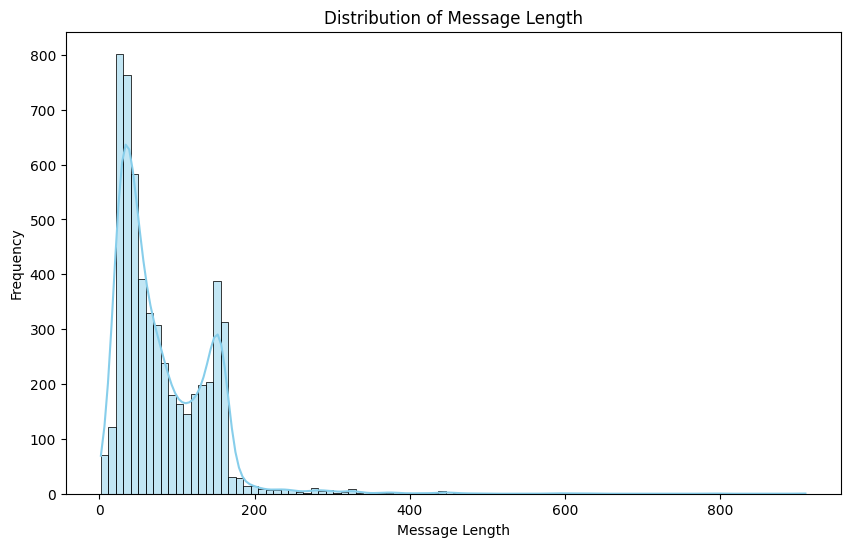

In [28]:
# Data Visualization
plt.figure(figsize=(10, 6))
sns.histplot(data['message_length'], kde=True, color='skyblue')
plt.title('Distribution of Message Length')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

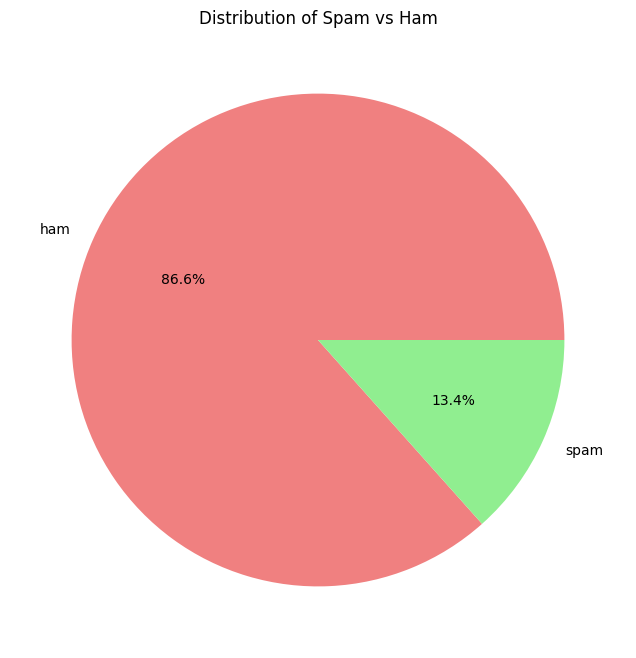

In [29]:
plt.figure(figsize=(8, 8))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Distribution of Spam vs Ham')
plt.ylabel('')
plt.show()

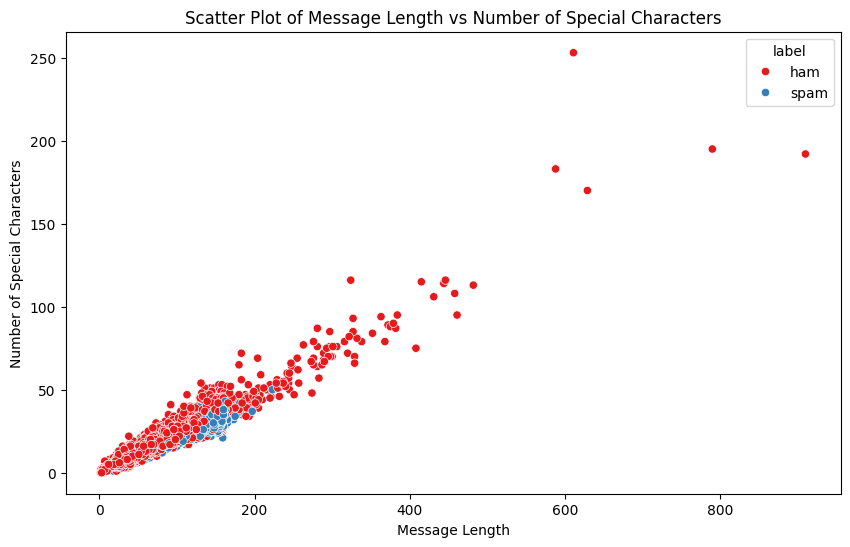

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='message_length', y='num_special_chars', hue='label', data=data, palette='Set1')
plt.title('Scatter Plot of Message Length vs Number of Special Characters')
plt.xlabel('Message Length')
plt.ylabel('Number of Special Characters')
plt.show()

In [31]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_text_tfidf = vectorizer.fit_transform(X_text)

In [32]:
# Convert TF-IDF matrix to integer counts
X_text_counts = X_text_tfidf.astype(np.int64)

In [33]:
# Standardize additional features
scaler = StandardScaler()
X_additional_scaled = scaler.fit_transform(X_additional)

In [34]:
# Combine TF-IDF features and additional features
X_combined = np.hstack((X_text_counts.toarray(), X_additional_scaled))

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [36]:
# Define models
models = {
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [37]:
# Train models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_score = f1(y_test, y_pred, pos_label='spam')
    conf_matrix = confusion_matrix(y_test, y_pred)
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "f1_score": f1_score,
        "confusion_matrix": conf_matrix
    }

Training SVM...
Training Random Forest...
Training Logistic Regression...
Training K Nearest Neighbors...
Training Decision Tree...
Training Gradient Boosting...


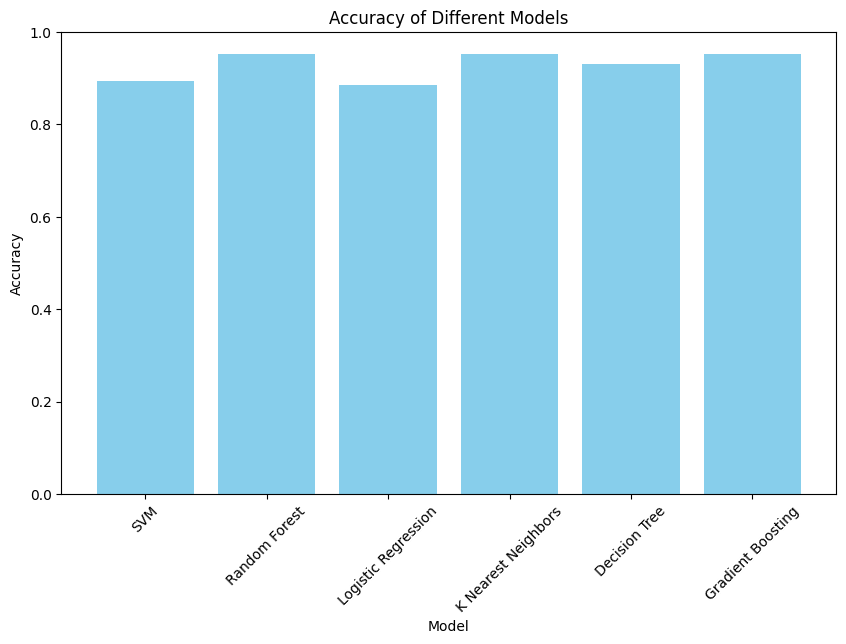

In [38]:
# Model Performance Metrics
model_accuracies = {name: result["accuracy"] for name, result in results.items()}
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

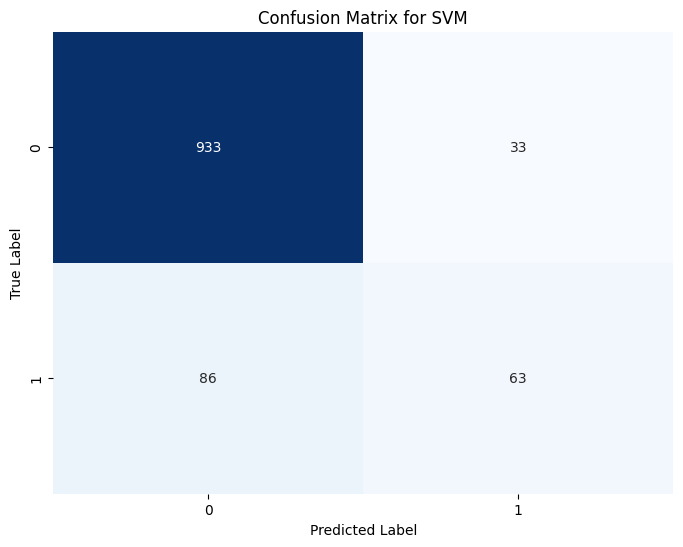

SVM Accuracy: 0.8932735426008969
SVM F1 Score: 0.5142857142857142


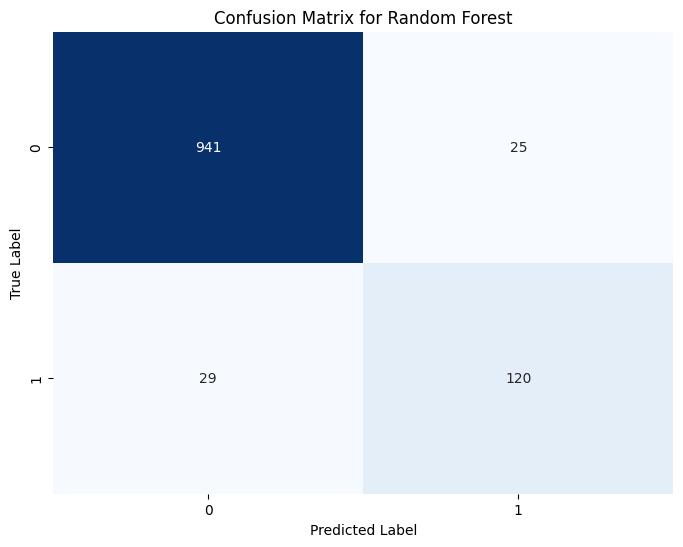

Random Forest Accuracy: 0.9515695067264573
Random Forest F1 Score: 0.8163265306122449


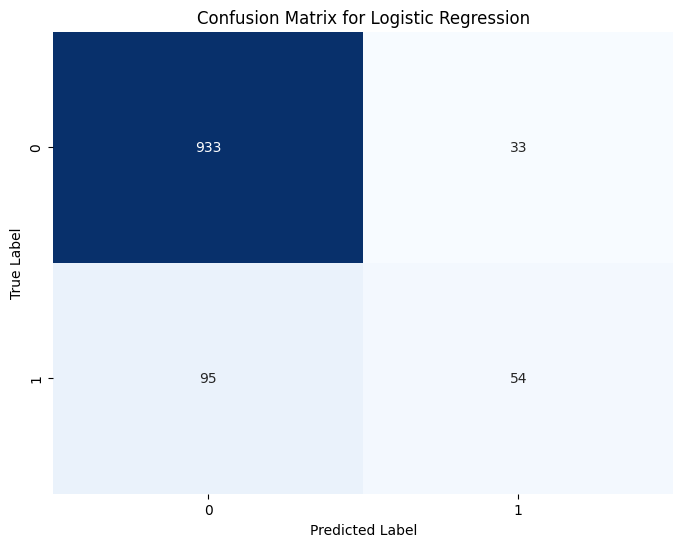

Logistic Regression Accuracy: 0.885201793721973
Logistic Regression F1 Score: 0.4576271186440678


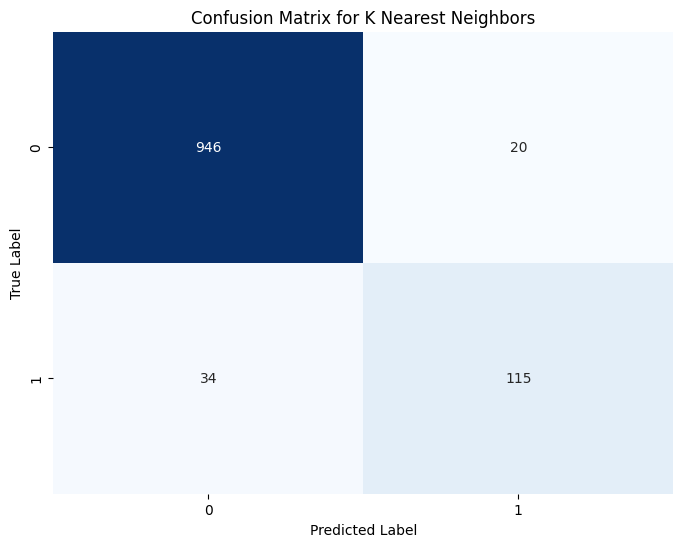

K Nearest Neighbors Accuracy: 0.9515695067264573
K Nearest Neighbors F1 Score: 0.8098591549295775


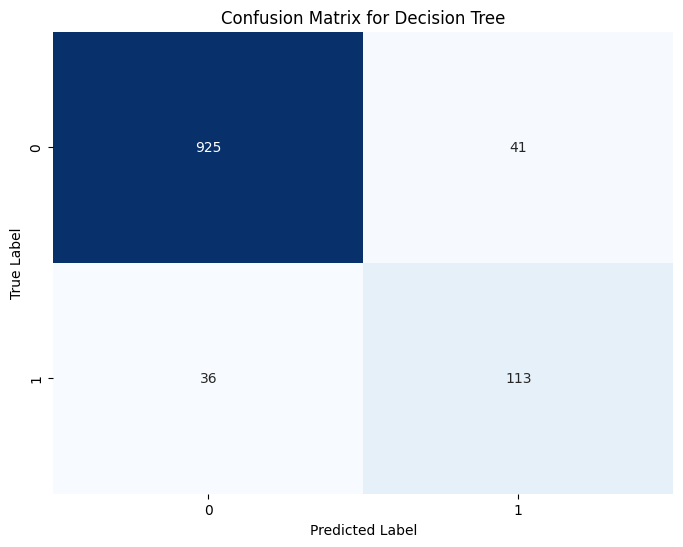

Decision Tree Accuracy: 0.9309417040358744
Decision Tree F1 Score: 0.7458745874587459


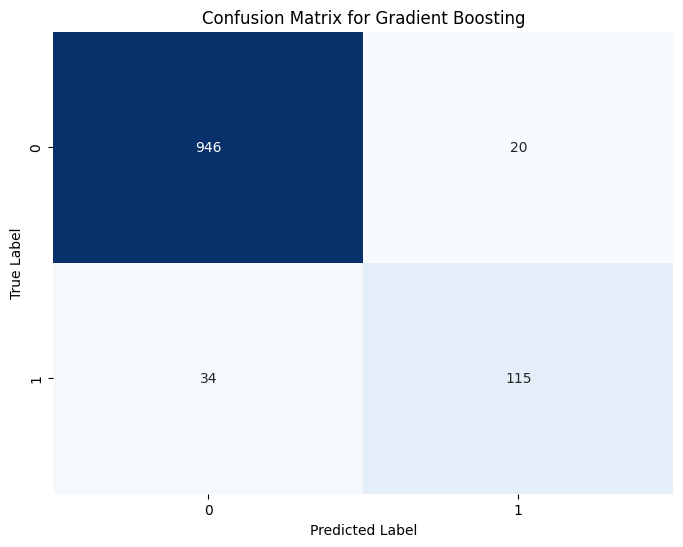

Gradient Boosting Accuracy: 0.9515695067264573
Gradient Boosting F1 Score: 0.8098591549295775


In [39]:
# Visualize results
for name, result in results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print(f"{name} Accuracy: {result['accuracy']}")
    print(f"{name} F1 Score: {result['f1_score']}")

In [40]:
# Find best model
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = results[best_model_name]["model"]
best_accuracy = results[best_model_name]["accuracy"]
print(f"Best Model: {best_model_name}, Accuracy: {best_accuracy}")

Best Model: Random Forest, Accuracy: 0.9515695067264573


In [41]:
# Save best model
joblib.dump(best_model, 'best_spam_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
# Interactive input
while True:
    user_input = input("Enter a message (or 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    else:
        # Load best model and preprocess input
        best_model = joblib.load('best_spam_model.pkl')
        vectorizer = joblib.load('tfidf_vectorizer.pkl')
        scaler = joblib.load('scaler.pkl')

        message_length = len(user_input)
        num_uppercase = sum(1 for c in user_input if c.isupper())
        num_special_chars = sum(1 for c in user_input if not c.isalnum())
        input_features = scaler.transform([[message_length, num_uppercase, num_special_chars]])
        input_text_tfidf = vectorizer.transform([user_input])
        input_combined = np.hstack((input_text_tfidf.toarray(), input_features))

        # Predict
        prediction = best_model.predict(input_combined)[0]
        result = "Spam" if prediction == 'spam' else "Not Spam"
        print(f'The message is: {result}')